# Machine Learning Classification Project
# Project Title : Predicting Future Humanitarian Assistance Needs

Develop a predictive model that can estimate the number of people who will require assistance in the future, specifically in the humanitarian context.

## Content
The dataset_beneficiaries.csv file contains data on 2936 people to be assisted by WFP in 4 regions of Burkina Faso.

1. Region: Region of people to be assisted 

2. State: State of people to be assisted in the concerned region

3. Commune: City of people to be assisted in the concerned state and region

4. Household Size: represents the size (in integer) of the household, i.e. the number of members in the household

5. Household Role: represents the head (HD) of household or his wife/husband/son/daughter. Generally, the assistance is given to the head of household

6. Recipient: represents the Principal (P) person or his Alternate (A) who is to benefit from the assistance. Generally, the head of household, who may be male or female, is considered to be the Principal.

7. Gender: represents the gender of the head (HD) of household : M for Male and F for Female 

8. Age: represents the age of the assisted people. It must be greater than or equal to 18 years, the age of majority in Burkina Faso.

9. Assistance Time: represents the date on which vulnerable persons must be assisted

10. Modality: represents the type of assistance mode: Cash, Food, e-Voucher

# Libraries importation

In [3]:
# Critical libraries
import scipy as sc
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

## Sklearn imports
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, BaseEnsemble

from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, cohen_kappa_score, roc_curve, auc

# Other
import pprint 
from copy import copy, deepcopy

## Load and explore data

In [4]:
# Load Excel file
df_excel = pd.read_excel("dataset_beneficiaries.xlsx")

# Save as CSV
df_excel.to_csv("dataset_beneficiaries.csv", index=False)

# Read CSV file
df_original = pd.read_csv("dataset_beneficiaries.csv")
df_original.head()

,Region,State,Commune,Household Size,Household Role,Recipient,Gender,Age,Assistance Time,Modality
0,Centre Nord,Sanmatenga,Boussouma,3,HD,P,F,55.0,2020-11-10,Cash
1,Centre Nord,Sanmatenga,Boussouma,12,HD,P,M,23.0,2020-11-10,Cash
2,Centre Nord,Sanmatenga,Boussouma,4,HD,P,M,29.0,2020-11-10,Cash
3,Centre Nord,Sanmatenga,Boussouma,8,HD,P,M,28.0,2020-11-10,Cash
4,Centre Nord,Sanmatenga,Boussouma,6,HD,P,M,29.0,2020-11-10,Cash


In [5]:
# Infos verification
df_original.info()

#number of rows and columns in the dataset
df_original.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Region           2936 non-null   object 
 1   State            2936 non-null   object 
 2   Commune          2936 non-null   object 
 3   Household Size   2936 non-null   int64  
 4   Household Role   2936 non-null   object 
 5   Recipient        2936 non-null   object 
 6   Gender           2909 non-null   object 
 7   Age              2926 non-null   float64
 8   Assistance Time  2936 non-null   object 
 9   Modality         2936 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 229.5+ KB


(2936, 10)

In [6]:
# Summarize numerical variables
df_original.describe()

,Household Size,Age
count,2936.000000,2926.000000
mean,10.002044,45.316473
std,4.920076,15.342995
min,1.000000,18.000000
25%,7.000000,34.000000
50%,9.000000,44.000000
75%,13.000000,55.000000
max,37.000000,103.000000


In [7]:
# Summarize categorical variables
column_names = df_original.select_dtypes(include=['object']).columns.values
if len(column_names) == 0:
    print("No object dtype columns")
else:
    df_original[column_names].describe()

In [8]:
# Stats on categorical variables
df_original[column_names].describe()

,Region,State,Commune,Household Role,Recipient,Gender,Assistance Time,Modality
count,2936,2936,2936,2936,2936,2909,2936,2936
unique,4,7,14,1,1,2,8,3
top,Est,Gnagna,Thion,HD,P,M,2021-06-25,Cash
freq,1644,1644,1644,2936,2936,1574,730,1214


# Prepare Dataset

In [9]:
# Make a copy of the original dataset
df = df_original.copy()
df

,Region,State,Commune,Household Size,Household Role,Recipient,Gender,Age,Assistance Time,Modality
0,Centre Nord,Sanmatenga,Boussouma,3,HD,P,F,55.0,2020-11-10,Cash
1,Centre Nord,Sanmatenga,Boussouma,12,HD,P,M,23.0,2020-11-10,Cash
2,Centre Nord,Sanmatenga,Boussouma,4,HD,P,M,29.0,2020-11-10,Cash
3,Centre Nord,Sanmatenga,Boussouma,8,HD,P,M,28.0,2020-11-10,Cash
4,Centre Nord,Sanmatenga,Boussouma,6,HD,P,M,29.0,2020-11-10,Cash
...,...,...,...,...,...,...,...,...,...,...
2931,Est,Gnagna,Thion,7,HD,P,M,21.0,2021-05-31,Food
2932,Est,Gnagna,Thion,5,HD,P,M,54.0,2021-05-31,Food
2933,Est,Gnagna,Thion,8,HD,P,F,60.0,2021-05-31,Food
2934,Est,Gnagna,Thion,5,HD,P,F,54.0,2021-05-31,Food


### Data Cleaning
#### Handling missing values

In [10]:
# Drop rows with missing values
df = df.dropna()
df

,Region,State,Commune,Household Size,Household Role,Recipient,Gender,Age,Assistance Time,Modality
0,Centre Nord,Sanmatenga,Boussouma,3,HD,P,F,55.0,2020-11-10,Cash
1,Centre Nord,Sanmatenga,Boussouma,12,HD,P,M,23.0,2020-11-10,Cash
2,Centre Nord,Sanmatenga,Boussouma,4,HD,P,M,29.0,2020-11-10,Cash
3,Centre Nord,Sanmatenga,Boussouma,8,HD,P,M,28.0,2020-11-10,Cash
4,Centre Nord,Sanmatenga,Boussouma,6,HD,P,M,29.0,2020-11-10,Cash
...,...,...,...,...,...,...,...,...,...,...
2931,Est,Gnagna,Thion,7,HD,P,M,21.0,2021-05-31,Food
2932,Est,Gnagna,Thion,5,HD,P,M,54.0,2021-05-31,Food
2933,Est,Gnagna,Thion,8,HD,P,F,60.0,2021-05-31,Food
2934,Est,Gnagna,Thion,5,HD,P,F,54.0,2021-05-31,Food


#### Handling duplicates

In [11]:
df = df.drop_duplicates()
df

,Region,State,Commune,Household Size,Household Role,Recipient,Gender,Age,Assistance Time,Modality
0,Centre Nord,Sanmatenga,Boussouma,3,HD,P,F,55.0,2020-11-10,Cash
1,Centre Nord,Sanmatenga,Boussouma,12,HD,P,M,23.0,2020-11-10,Cash
2,Centre Nord,Sanmatenga,Boussouma,4,HD,P,M,29.0,2020-11-10,Cash
3,Centre Nord,Sanmatenga,Boussouma,8,HD,P,M,28.0,2020-11-10,Cash
4,Centre Nord,Sanmatenga,Boussouma,6,HD,P,M,29.0,2020-11-10,Cash
...,...,...,...,...,...,...,...,...,...,...
2931,Est,Gnagna,Thion,7,HD,P,M,21.0,2021-05-31,Food
2932,Est,Gnagna,Thion,5,HD,P,M,54.0,2021-05-31,Food
2933,Est,Gnagna,Thion,8,HD,P,F,60.0,2021-05-31,Food
2934,Est,Gnagna,Thion,5,HD,P,F,54.0,2021-05-31,Food


### Data Visualization

In [12]:
# Checking correlation between the following columns: 'Household Size' and 'Modality' 
df1=df[['Household Size','Age']] 
df1

,Household Size,Age
0,3,55.0
1,12,23.0
2,4,29.0
3,8,28.0
4,6,29.0
...,...,...
2931,7,21.0
2932,5,54.0
2933,8,60.0
2934,5,54.0


array([[<Axes: title={'center': 'Household Size'}>,
        <Axes: title={'center': 'Age'}>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

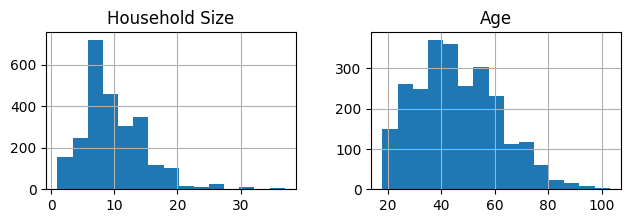

In [74]:
# Histogram of "Household Size" and "Age" columns
df1.hist(bins=15,figsize=(20, 10), layout=(4, 5))

<Figure size 200x500 with 0 Axes>

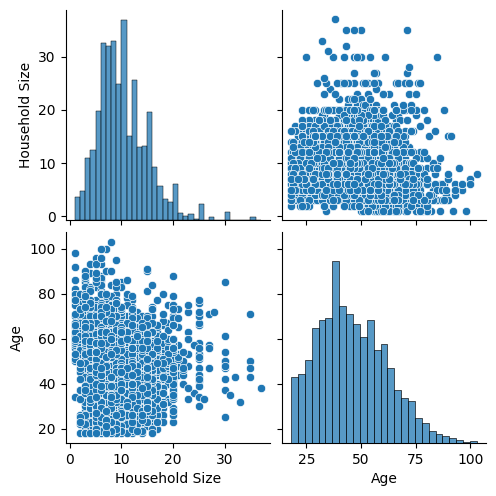

In [13]:
# Display of the correlation matrix in the form of point clouds
plt.figure(figsize=(2,5))
sb.pairplot(df1) # several point clouds

In [15]:
df1.corr()

,Household Size,Age
Household Size,1.000000,-0.026832
Age,-0.026832,1.000000


### Determine feature and target dataset

In [23]:
# Categorial variables have to be converted to numerical variables
X = df.drop(columns=["Modality", "Assistance Time"])
y = df['Modality']
X_dummies = pd.get_dummies(X, drop_first=True)

In [24]:
X_dummies.head()

,Household Size,Age,Region_Est,Region_Nord,Region_Plateau Central,State_Gnagna,State_Oubritenga,State_Passoré,State_Sanmatenga,State_Yatenga,...,Commune_Korsimoro,Commune_Kossouka,Commune_Oula,Commune_Rambo,Commune_Thion,Commune_Ziteenga,Commune_Zitenga,Commune_Zitenga,Commune_Zorgho,Gender_M
0,3,55.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,12,23.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,4,29.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,8,28.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,6,29.0,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [25]:
y.head()

0    Cash
1    Cash
2    Cash
3    Cash
4    Cash
Name: Modality, dtype: object

### Train test-split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.25, stratify=y, random_state=1)

print("Dimensions:")
print("X_train:", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

Dimensions:
X_train: (1894, 25)
X_test:  (632, 25)
y_train (1894,)
y_test (632,)


## Building the model: Decision Tree

### Training the model

In [28]:
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)
print(model)

DecisionTreeClassifier(random_state=1)


In [29]:
model.score(X_train, y_train)

0.9229144667370645

In [30]:
model.predict(X_train)

array(['E-voucher', 'Cash', 'E-voucher', ..., 'Cash', 'E-voucher', 'Cash'],
      dtype=object)

In [31]:
model.score(X_test, y_test)

0.5996835443037974